# 8.3. Leveraging a pretrained model
We will use pretrained VGG16 model for two tasks:
- Feature extraction.
- Fine-tunning.

## Download Dataset

In [1]:
!rm -rf convnet_from_scratch.keras train cats_vs_dogs_small test1

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
# import libraries
import os
import zipfile
import pandas as pd
import os, shutil, pathlib
import matplotlib.pyplot as plt
import numpy as np

# import TF
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [4]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    z.close()
    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
    z.close()

In [5]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  test1  train


### Copy images to training, validation, and test directories

In [6]:
# set paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [8]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [9]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
!ls cats_vs_dogs_small/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
test  train  validation


# 8.3.1 Feature Extraction

In [11]:
# instantiate the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,        # not to incluse the densely connected classifier
    input_shape=(180, 180, 3) # optional, the network can process inputs any size, pass here to see how feature map shrink
)

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Note**: Here we have 2 ways
- Run the convolutional base over the dataset, record its output to numpy array on disk and then use data as input to a standablone, densely connected classifier similar to those you saw in chapter 4. This solution is fast and cheap to run, becuase it only requires running the convolutional base once for every input image and the convolutional base is by far the most expensive part of the pipeline. However, this technique won't allow us to use data augmentation.
- Extend the model we have (conv_base) by adding Dense layers on top, and run thw whole thing from end to end on input data. This will allow us to use data augmentation, becuase every input image goes thru the conv_base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

## A. Extracting the VGG16 features and corresponding labels

In [13]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [14]:
train_features.shape

(2000, 5, 5, 512)

### Define and train densely connected classifier

In [15]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [16]:
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 11.6261 - accuracy: 0.9275 - val_loss: 10.2493 - val_accuracy: 0.9380
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 5.1430 - accuracy: 0.9730 - val_loss: 6.2700 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.9885 - accuracy: 0.9860 - val_loss: 9.1295 - val_accuracy: 0.9600
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.3301 - accuracy: 0.9870 - val_loss: 4.7229 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0251 - accuracy: 0.9910 - val_loss: 3.9545 - val_accuracy: 0.9820
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0707 - accuracy: 0.9920 - val_loss: 7.1210 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3222 - accuracy: 0.9970 - val_loss: 4.7954 - val_accuracy: 0.9810
Epoch 8/20
63/63 [

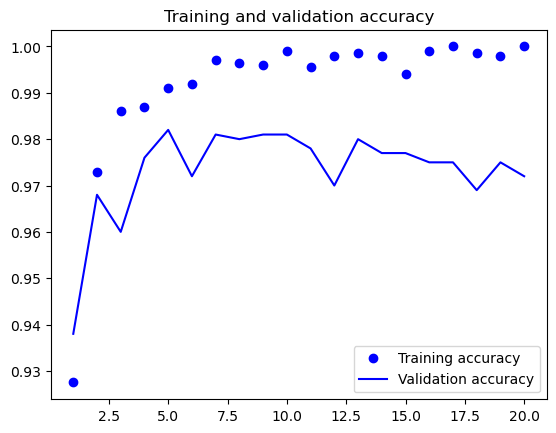

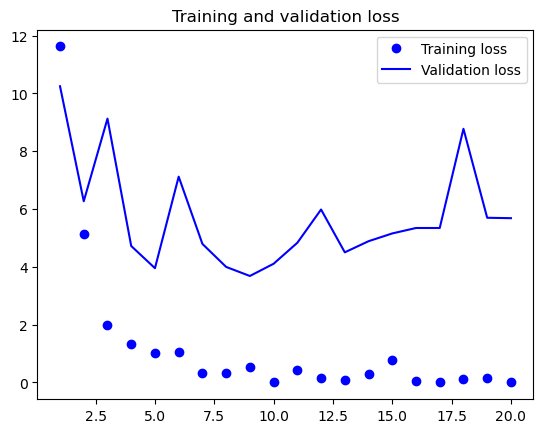

In [17]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## B. Feature Extraction Together With Data Augmentation
- First, we need to freeze the convolutional base. Freezing a layer or a set of layers means preventing thei weights from being updated during training. If we don't do this, the representations that were previously learned by the convolutional base will be modified during training.

In [18]:
# import the model
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

# freeze layer
conv_base.trainable = False

In [19]:
# let print out the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


### Adding data augmentation stage and classifier to the convolutional base

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)

x = keras.applications.vgg16.preprocess_input(x)

x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

**Note**: with this set up, only the weights from 2 Dense layers we added will be trained. This way only works if you have access to GPU.

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [23]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 9s 124ms/step - loss: 18.8539 - accuracy: 0.9025 - val_loss: 3.4335 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 8s 123ms/step - loss: 6.7617 - accuracy: 0.9460 - val_loss: 41.1807 - val_accuracy: 0.8460
Epoch 3/20
63/63 [==============================] - 8s 125ms/step - loss: 6.8212 - accuracy: 0.9530 - val_loss: 2.8929 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 8s 123ms/step - loss: 6.4853 - accuracy: 0.9565 - val_loss: 3.1655 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 8s 120ms/step - loss: 3.1975 - accuracy: 0.9725 - val_loss: 4.4753 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 8s 119ms/step - loss: 4.1466 - accuracy: 0.9620 - val_loss: 2.9800 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 8s 124ms/step - loss: 3.8399 - accuracy: 0.9705 - val_loss: 2.9093 - val_accuracy: 0.9780
Epoc

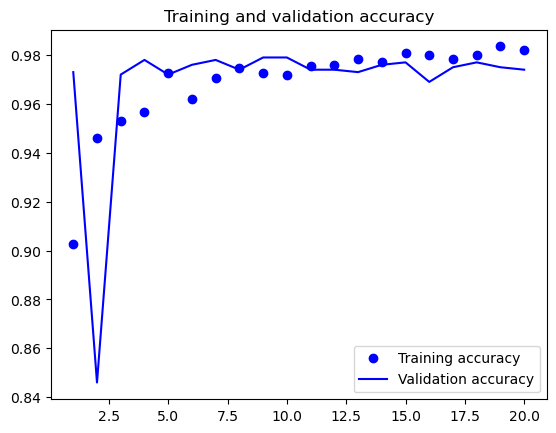

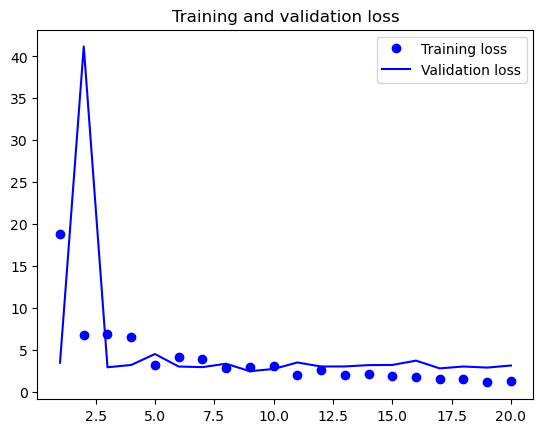

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [25]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 59ms/step - loss: 4.1430 - accuracy: 0.9745
Test accuracy: 0.975


# 8.3.2. Fine-tuning a pretrained model
- For this application, we will fine-tune the last 3 convolutional layers. which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.
- 

In [26]:
# import the model
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

# freeze layer
conv_base.trainable = False

In [27]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Freeze all layers until the fourth from the last

In [28]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Fine-tuning the model

In [29]:
model.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 124ms/step - loss: 1.1997 - accuracy: 0.9870 - val_loss: 3.0685 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - 8s 121ms/step - loss: 1.1328 - accuracy: 0.9845 - val_loss: 3.0375 - val_accuracy: 0.9750
Epoch 3/30
63/63 [==============================] - 8s 124ms/step - loss: 1.1272 - accuracy: 0.9820 - val_loss: 3.0168 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 8s 131ms/step - loss: 1.1608 - accuracy: 0.9875 - val_loss: 2.9942 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 8s 123ms/step - loss: 1.1509 - accuracy: 0.9860 - val_loss: 2.9829 - val_accuracy: 0.9770
Epoch 6/30
63/63 [==============================] - 8s 117ms/step - loss: 0.9486 - accuracy: 0.9885 - val_loss: 2.9959 - val_accuracy: 0.9740
Epoch 7/30
63/63 [==============================] - 8s 125ms/step - loss: 0.7358 - accuracy: 0.9910 - val_loss: 2.9954 - val_accuracy: 0.9740
Epoch 

In [30]:
# test model
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 59ms/step - loss: 2.2653 - accuracy: 0.9800
Test accuracy: 0.980
